In [1]:
# Imports
from src.json_utils import read_jsonl
from src.config import DATA_DIR
import pandas as pd
import os

In [30]:
data = read_jsonl('../data/dkpol_tweets.jsonl')

Reading ../data/dkpol_tweets.jsonl


AttributeError: 'list' object has no attribute 'info'

In [29]:
df = pd.DataFrame([i['created_at'] for i in data], columns=['timestamp'])
df.timestamp = pd.to_datetime(df.timestamp)
df.info()
df[['timestamp', ]].groupby(df.timestamp.dt.to_period("M")).agg('count').plot(kind='bar')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70170 entries, 0 to 70169
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype              
---  ------     --------------  -----              
 0   timestamp  70170 non-null  datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](1)
memory usage: 548.3 KB


TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'RangeIndex'

In [62]:
df = pd.DataFrame(data)
df[df['in_reply_to_user_id'].isna()]
df.created_at = pd.to_datetime(df.created_at)
sub = df[['created_at', 'text']].groupby(df.created_at.dt.to_period("M")).head(350)

<AxesSubplot:xlabel='created_at'>

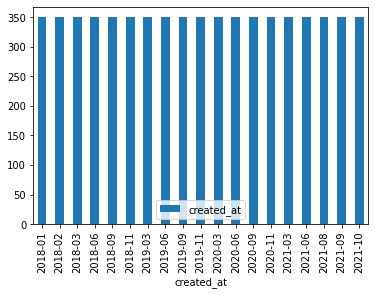

In [63]:
sub[['created_at']].groupby(df.created_at.dt.to_period("M")).agg('count').plot(kind='bar')

### Embedding Methods

**Resources**
- https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0

### Td-idf

In [24]:
# Imports 

import spacy
from src.config import DATA_DIR
from src.json_utils import read_jsonl
from preprocessing import *
import re
from nltk.tokenize import TweetTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pylab as plt
from sentence_transformers import SentenceTransformer
import seaborn as sns
import pandas as pd
import numpy as np
from pprint import pprint
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse
from tqdm import tqdm

In [25]:
# Define util functions

with open('../data/danish_stopwords.txt') as stop_file:
    stopwords = [word.strip() for word in stop_file.readlines()]


def remove_newlines(text: str) -> str:
    return re.sub(r'\n+', ' ', text)


def normalize_spaces(text: str) -> str:
    return re.sub(r'\s{2,}', ' ', text)


def remove_punctuation(text: str) -> str:
    return re.sub('[:,\\.!?\'\"\\”\\(\\)\\/\\-]', '', text)


def is_website_token(token: str) -> str:
    if token[:4] == 'http':
        return ''
    else:
        return token

# def cosine_similarity(matrix):
#     norm = pd.DataFrame(np.sqrt(np.square(matrix).sum(axis = 0)))
#     denominator = norm.dot(norm.T)
#     numerator = matrix.dot(matrix.T)
#     similarity_matrix = numerator.divide(denominator,axis =1)
#     return similarity_matrix

In [35]:
# Prepare data for embedding

preprocessing_func = [remove_punctuation, str.lower, is_website_token]

tweet_tokenizer = TweetTokenizer()

data = read_jsonl('../data/dkpol_tweets.jsonl')

df = pd.DataFrame(data)
df[df['in_reply_to_user_id'].isna()]
df.created_at = pd.to_datetime(df.created_at)
sub = df[['created_at', 'text']].groupby(df.created_at.dt.to_period("M")).head(350)
text = list(sub['text'].values)
tokenized_text = [[token for token in tweet_tokenizer.tokenize(i) if token not in stopwords] for i in text]

all_tokenizer_text = []

for text in tokenized_text:
    post_precessed = []
    for token in text:
        for function in preprocessing_func:
            token = function(token)
        if token != '':
            post_precessed.append(token)
    all_tokenizer_text.append(' '.join(post_precessed))

Reading ../data/dkpol_tweets.jsonl


/Users/hrmussa/.pyenv/versions/3.8.9/envs/ditw/lib/python3.8/site-packages/pandas/core/arrays/datetimes.py:1143: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


In [36]:
vectorizer = TfidfVectorizer(tokenizer = TweetTokenizer().tokenize, max_features=5000, stop_words=None, ngram_range=(1, 3), min_df=10, max_df=0.85)
X = vectorizer.fit_transform(all_tokenizer_text)
print(X.shape)

(7155, 2430)


In [37]:
# Get all pairwise cosine similarities

A_sparse = sparse.csr_matrix(X)

#also can output sparse matrices
similarities_sparse = cosine_similarity(A_sparse,dense_output=False)
#print('pairwise sparse output:\n {}\n'.format(similarities_sparse))
similarities_sparse

<7155x7155 sparse matrix of type '<class 'numpy.float64'>'
	with 6199979 stored elements in Compressed Sparse Row format>

In [38]:
# Get all pairs of cosine similarities above 0

dict_of_similarities = {}
x, y = similarities_sparse.nonzero()[0], similarities_sparse.nonzero()[1] 
for i, j in tqdm(zip(x,y)):
    if (i, j) not in dict_of_similarities and(j, i) not in dict_of_similarities and round(similarities_sparse[i, j], 5) != 1:
        dict_of_similarities[(i, j)] = similarities_sparse[i, j]

print(len(dict_of_similarities))

6199979it [01:57, 52929.14it/s] 

3090723


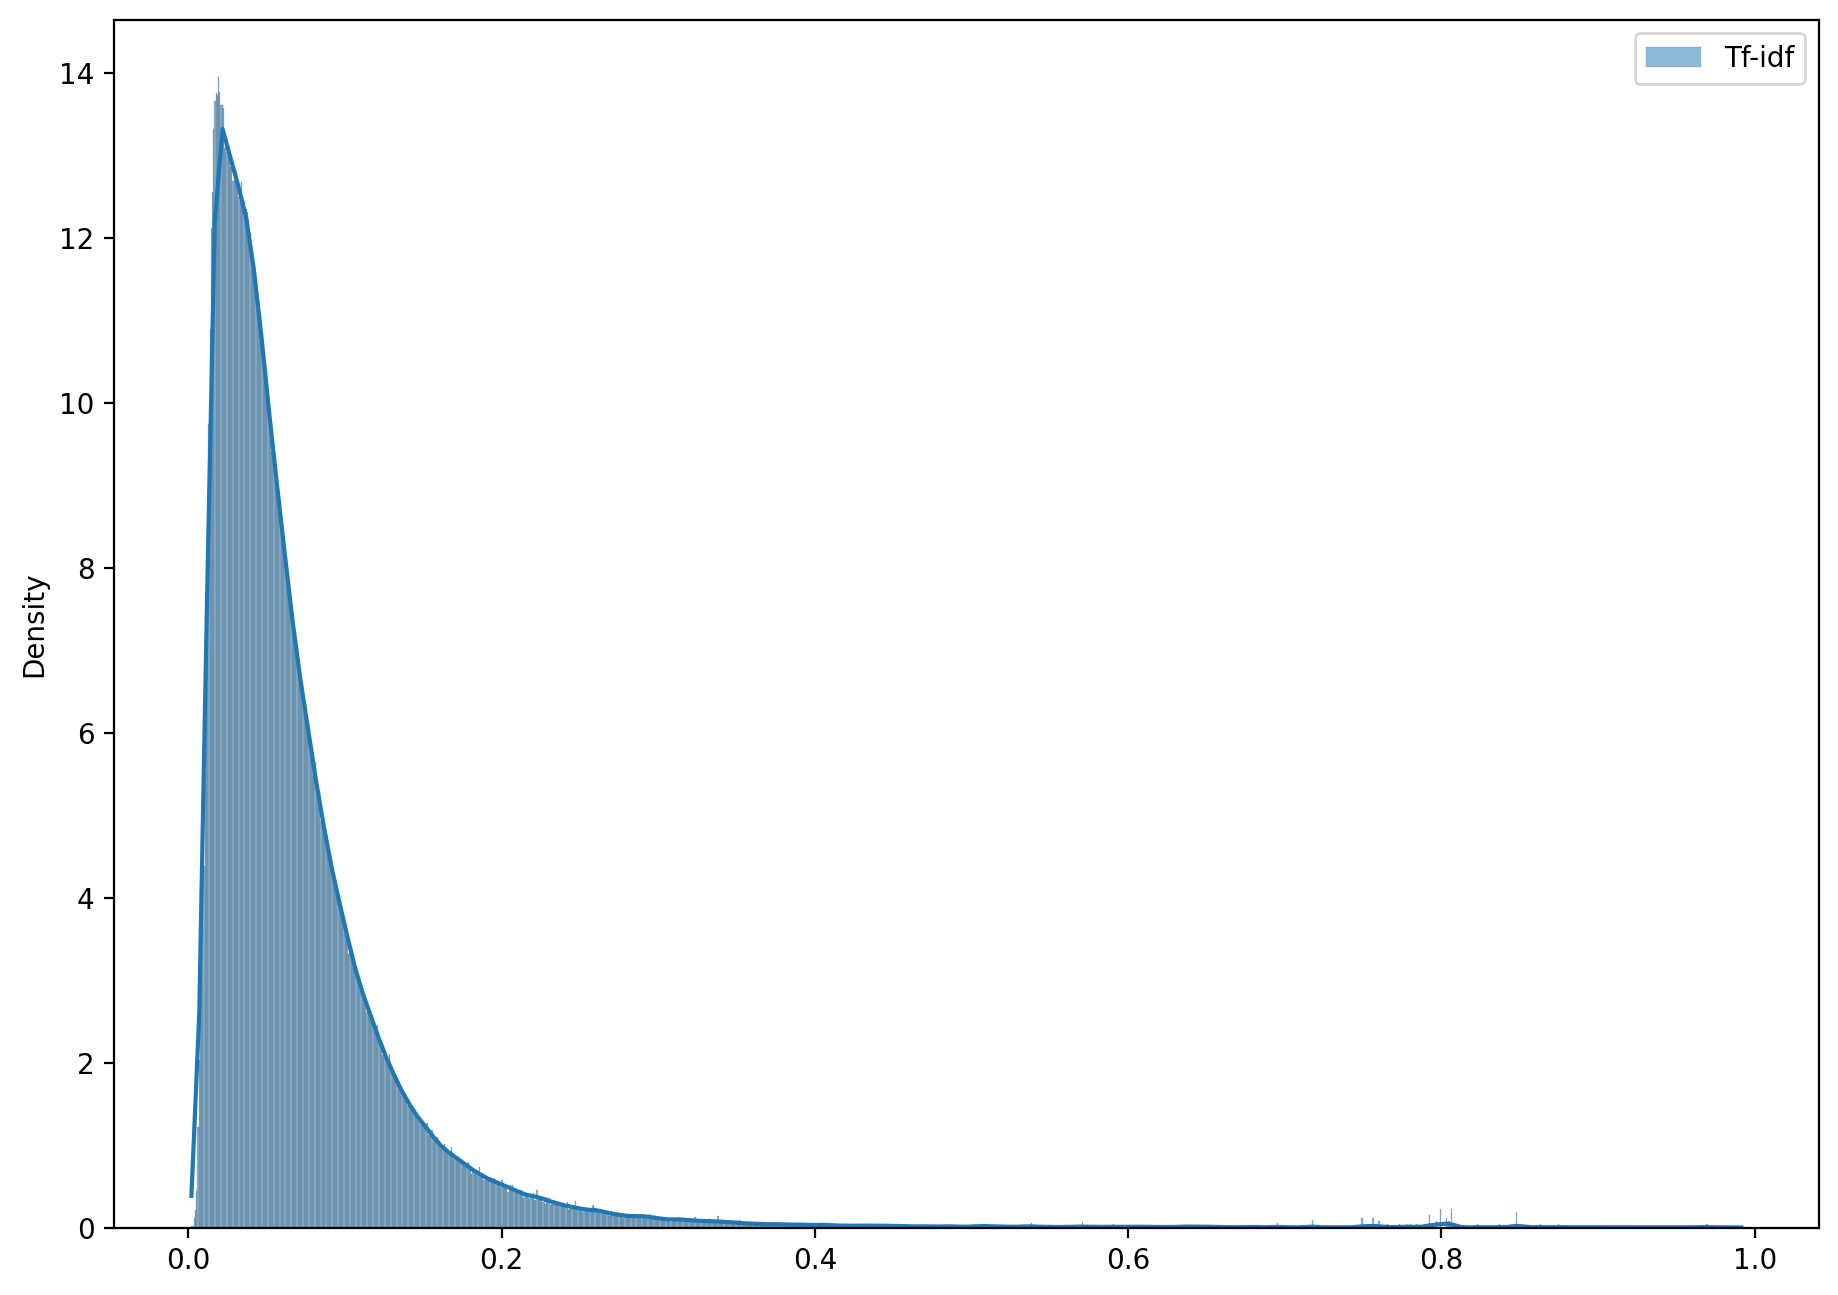

In [39]:
# Plot
#kwargs = dict(hist_kws={'alpha':.6}, kde_kws={'linewidth':2})

plt.figure(figsize=(11,8), dpi= 200)
#sns.distplot(list(dict_of_similarities.values()), color="dodgerblue", label="Td-idf", **kwargs)
sns.histplot(list(dict_of_similarities.values()), stat='density', kde=True, label = 'Tf-idf')
plt.legend()
plt.savefig('../data/img/tf_ifd_cossim_dist.png')
plt.show()

In [34]:
len(text)

27

In [42]:
for idx_t, val in dict_of_similarities.items():
    if val >  0.2 and val < 0.4:
        one, two = idx_t
        print(all_tokenizer_text[one])
        print(all_tokenizer_text[two])
        print(val)
        print('----------------------')

lige @skaarup_df populær #dkpol
lige @socialized_dk populær #dkpol
0.7997531862502675
----------------------
lige @skaarup_df populær #dkpol
lige @soreneggerasmus populær #dkpol
0.7997531862502675
----------------------
lige @skaarup_df populær #dkpol
lige @tryberg populær #dkpol
0.7997531862502675
----------------------
lige @skaarup_df populær #dkpol
lige @simonpihl populær #dkpol
0.7997531862502675
----------------------
lige @skaarup_df populær #dkpol
lige @socialized_dk populær #dkpol
0.7997531862502675
----------------------
lige @skaarup_df populær #dkpol
lige @socialized_dk populær #dkpol
0.7997531862502675
----------------------
lige @skaarup_df populær #dkpol
lige @simonpihl populær #dkpol
0.7997531862502675
----------------------
lige @skaarup_df populær #dkpol
lige @socialized_dk populær #dkpol
0.7997531862502675
----------------------
lige @skaarup_df populær #dkpol
lige @ulrikkohl populær #dkpol
0.7997531862502675
----------------------
lige @skaarup_df populær #dkpol
lig

### Ælæctra

In [6]:
# Prepare data
data = read_jsonl('../data/dkpol_tweets.jsonl')
df = pd.DataFrame(data)
df[df['in_reply_to_user_id'].isna()]
df.created_at = pd.to_datetime(df.created_at)
sub = df[['created_at', 'text']].groupby(df.created_at.dt.to_period("M")).head(350)
text = list(sub['text'].values)
text = replace_url(text)
len(text)

Reading ../data/dkpol_tweets.jsonl


7155

In [11]:
# Embed texts
encoder = SentenceTransformer('Maltehb/-l-ctra-danish-electra-small-cased')
embeddings = encoder.encode(text, show_progress_bar=True, normalize_embeddings=True)

Some weights of the model checkpoint at /Users/hrmussa/.cache/torch/sentence_transformers/Maltehb_-l-ctra-danish-electra-small-cased were not used when initializing ElectraModel: ['generator.encoder.layer.11.attention.self.value.weight', 'generator.encoder.layer.8.attention.output.dense.bias', 'generator.encoder.layer.8.output.dense.weight', 'generator.encoder.layer.9.attention.self.query.weight', 'generator.encoder.layer.8.attention.self.key.bias', 'generator.encoder.layer.2.attention.self.key.weight', 'generator.encoder.layer.9.attention.output.LayerNorm.weight', 'generator_predictions.LayerNorm.bias', 'generator.encoder.layer.8.attention.self.value.bias', 'generator.encoder.layer.10.attention.self.key.bias', 'generator.encoder.layer.2.attention.output.LayerNorm.bias', 'generator.encoder.layer.0.attention.output.LayerNorm.bias', 'discriminator_predictions.classifier.bias', 'generator.encoder.layer.1.intermediate.dense.bias', 'generator.encoder.layer.10.attention.output.LayerNorm.bias

In [14]:
A_sparse = sparse.csr_matrix(embeddings)

#also can output sparse matrices
similarities_sparse = cosine_similarity(A_sparse,dense_output=False)
#print('pairwise sparse output:\n {}\n'.format(similarities_sparse))
similarities_sparse

<7155x7155 sparse matrix of type '<class 'numpy.float32'>'
	with 51194025 stored elements in Compressed Sparse Row format>

In [15]:
# Get all pairs of cosine similarities above 0

dict_of_similarities = {}
x, y = similarities_sparse.nonzero()[0], similarities_sparse.nonzero()[1] 
for i, j in tqdm(zip(x,y)):
    if (i, j) not in dict_of_similarities and(j, i) not in dict_of_similarities and similarities_sparse[i, j] != 1:
        dict_of_similarities[(i, j)] = similarities_sparse[i, j]

print(len(dict_of_similarities))

51194025it [18:52, 45222.16it/s] 

25598951


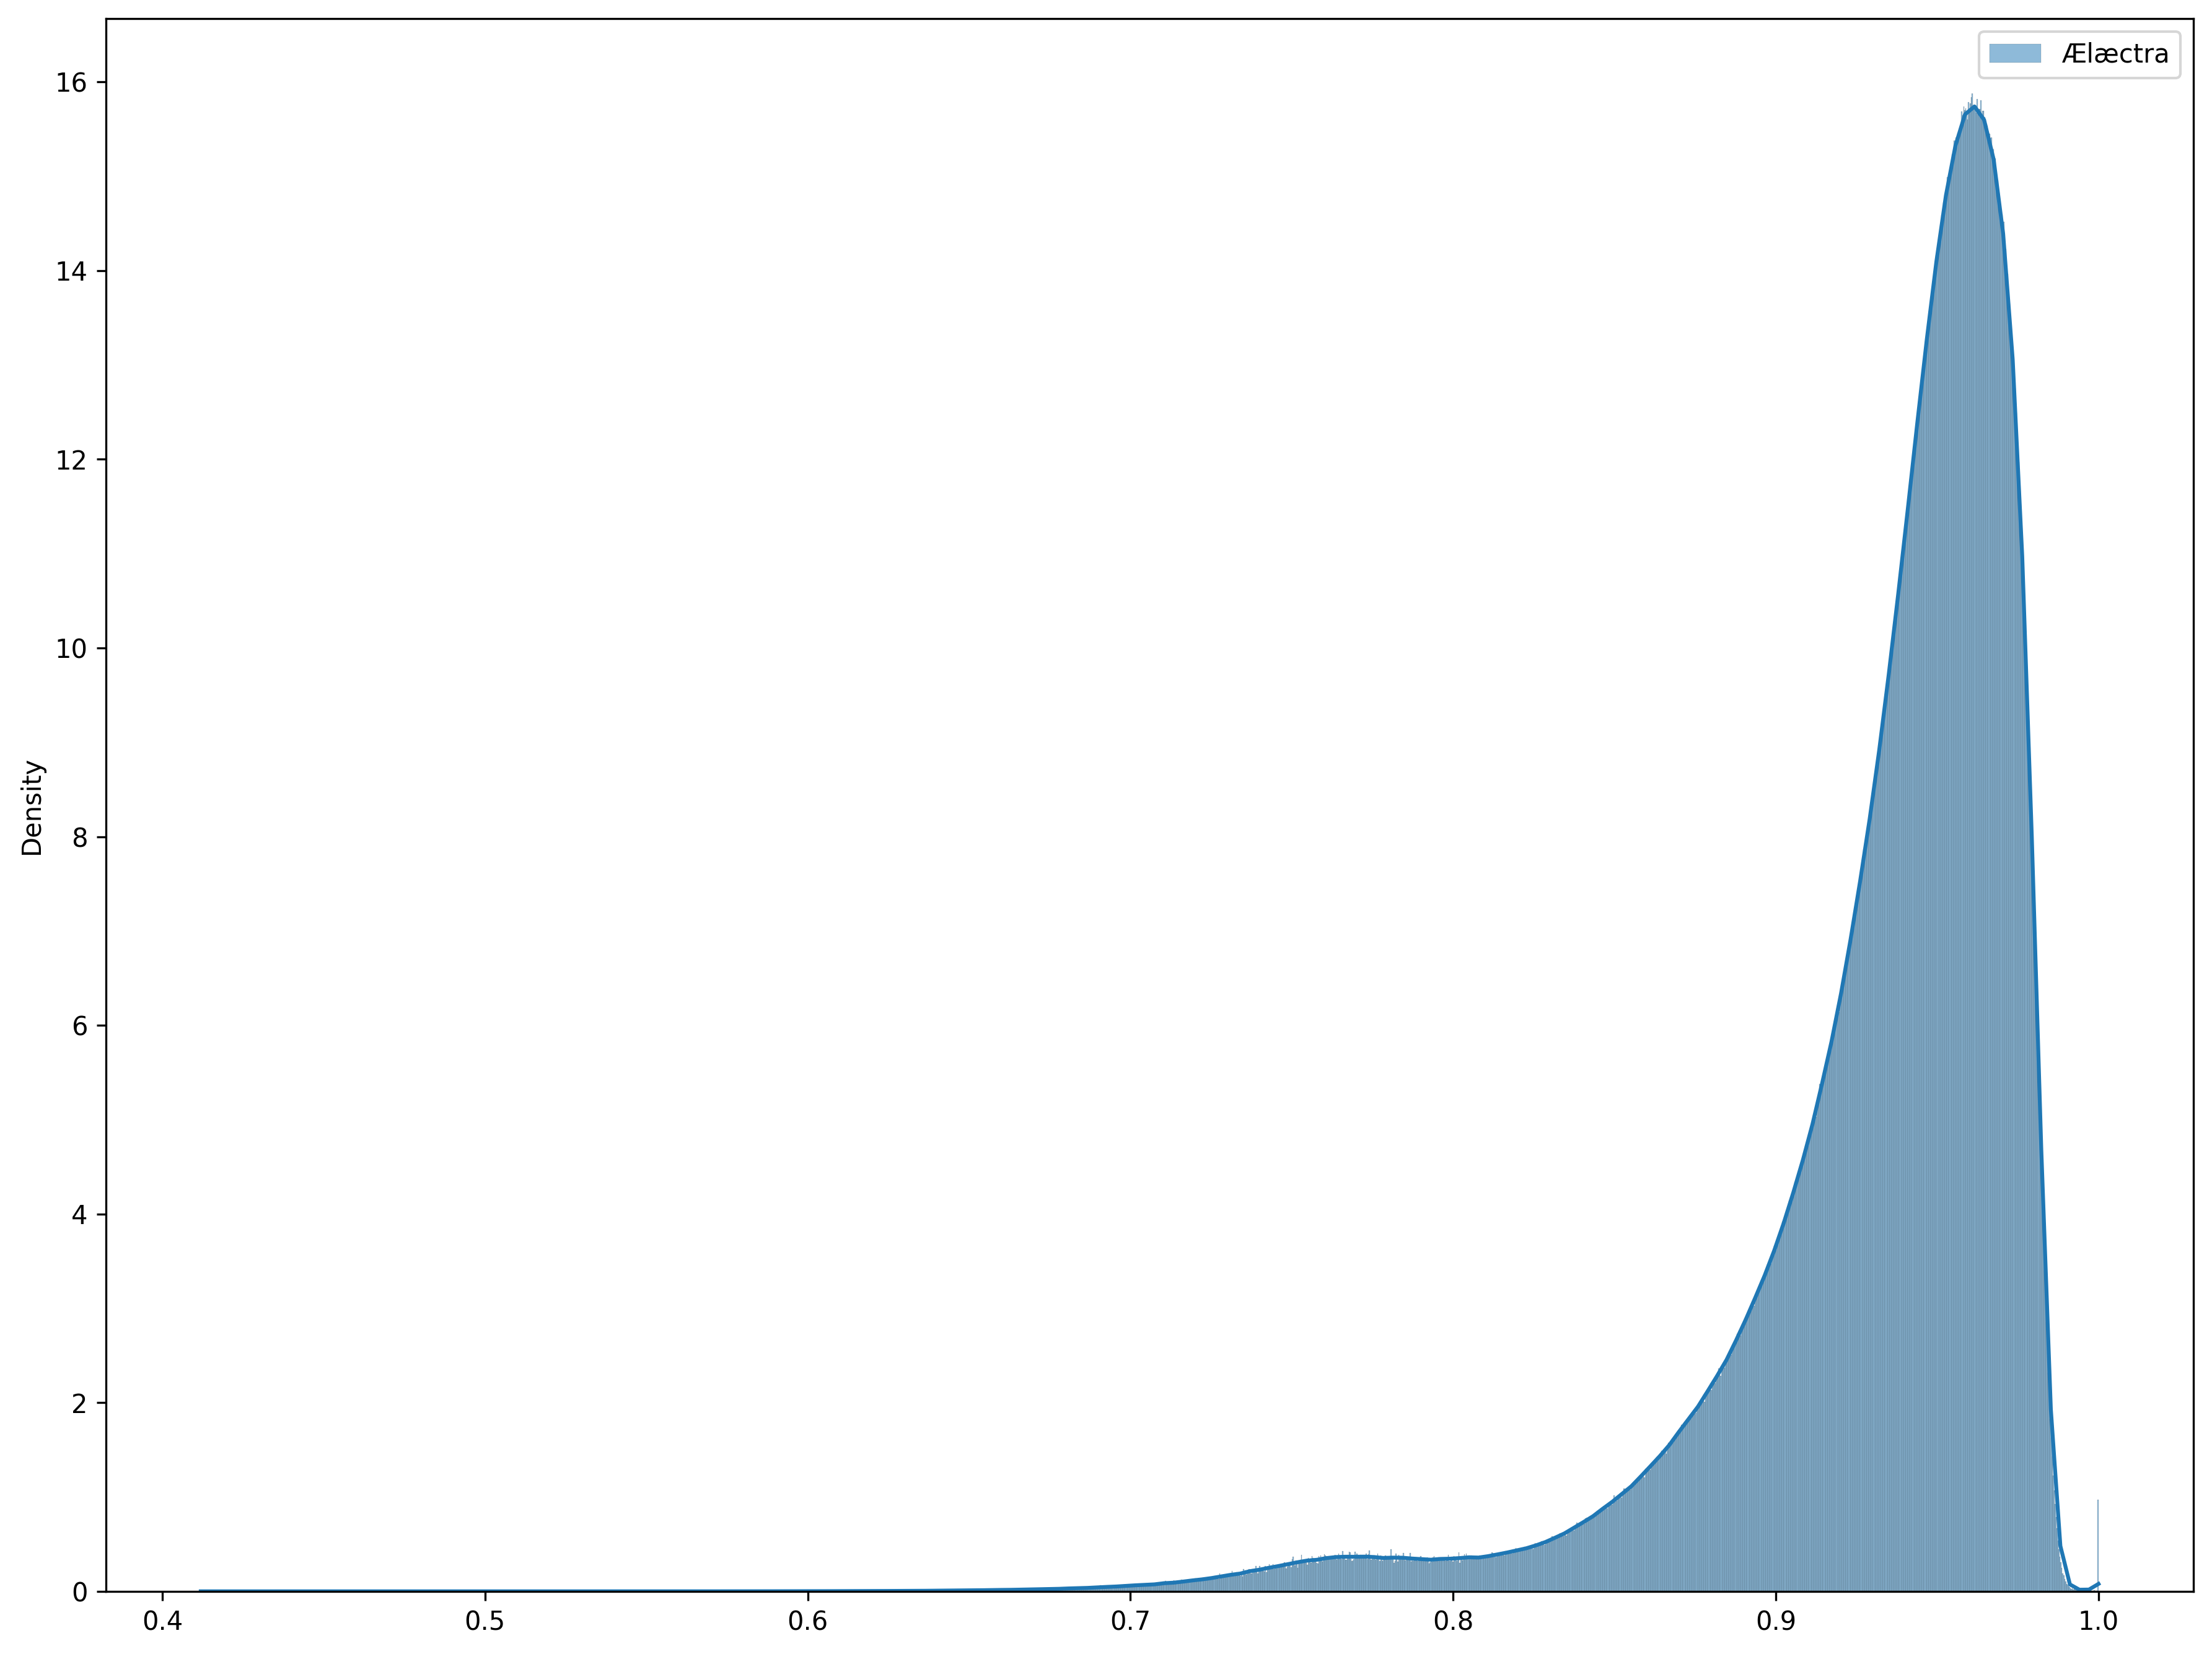

In [19]:
plt.figure(figsize=(12,9), dpi= 300)
#sns.distplot(list(dict_of_similarities.values()), color="dodgerblue", label="Td-idf", **kwargs)
sns.histplot(list(dict_of_similarities.values()), stat='density', kde=True, label = 'Ælæctra')
plt.legend()
plt.tight_layout()
plt.savefig('../data/img/_l_ctra_cossim_dist.png')
plt.show()

In [22]:
dict_of_similarities
print(text[0])
print()
print(text[7154])

Det er på tide køreprøver kommer i konkurrence og på private hænder. Ligesom med bilsyn. Væk med ventetider og styrket kvaliteten. #dkpol  URL

@Fiscker89 @MortenDDHansen @DRNyheder Og der er spørgsmålet så, er det rimeligt at folk i vest Jylland skal være bange for at sende deres børn ud at lege? Ligegyldigt hvor ubegrundet frygten er, så er folk der bor der, utrygge ved at have Ulve som naboer! #dkpol


### DaCy Model

In [23]:
# import spacy

import dacy
nlp = dacy.load("da_dacy_small_trf-0.1.0")
for doc in nlp.pipe(["Det her er en sjovt text", "Fodbold er rigtig kedeligt"]):
    tokvecs = doc._.trf_data.tensors[-1]
    print(tokvecs.shape)

# some_embeddings = np.vstack([doc._.trf_data.tensors[-1] for doc in tqdm(nlp.pipe(text))])

(1, 8, 256)
(1, 8, 256)


In [15]:
A_sparse = sparse.csr_matrix(some_embeddings)

#also can output sparse matrices
similarities_sparse = cosine_similarity(A_sparse,dense_output=False)
#print('pairwise sparse output:\n {}\n'.format(similarities_sparse))
similarities_sparse

<2x2 sparse matrix of type '<class 'numpy.float32'>'
	with 4 stored elements in Compressed Sparse Row format>

In [20]:
# Get all pairs of cosine similarities above 0

dict_of_similarities = {}
x, y = similarities_sparse.nonzero()[0], similarities_sparse.nonzero()[1] 
for i, j in tqdm(zip(x,y)):
    if (i, j) not in dict_of_similarities and(j, i) not in dict_of_similarities and round(similarities_sparse[i, j], 5) != 1:
        dict_of_similarities[(i, j)] = similarities_sparse[i, j]

print(len(dict_of_similarities))

4it [00:00, 9686.61it/s]

1


In [21]:
dict_of_similarities

{(0, 1): -0.2148652}